# Final Exam Project
## for the class on Collecting and Analyzing Big Data
---
Daria Dementeva - r0771521


Nina Morgenstern - r0772330

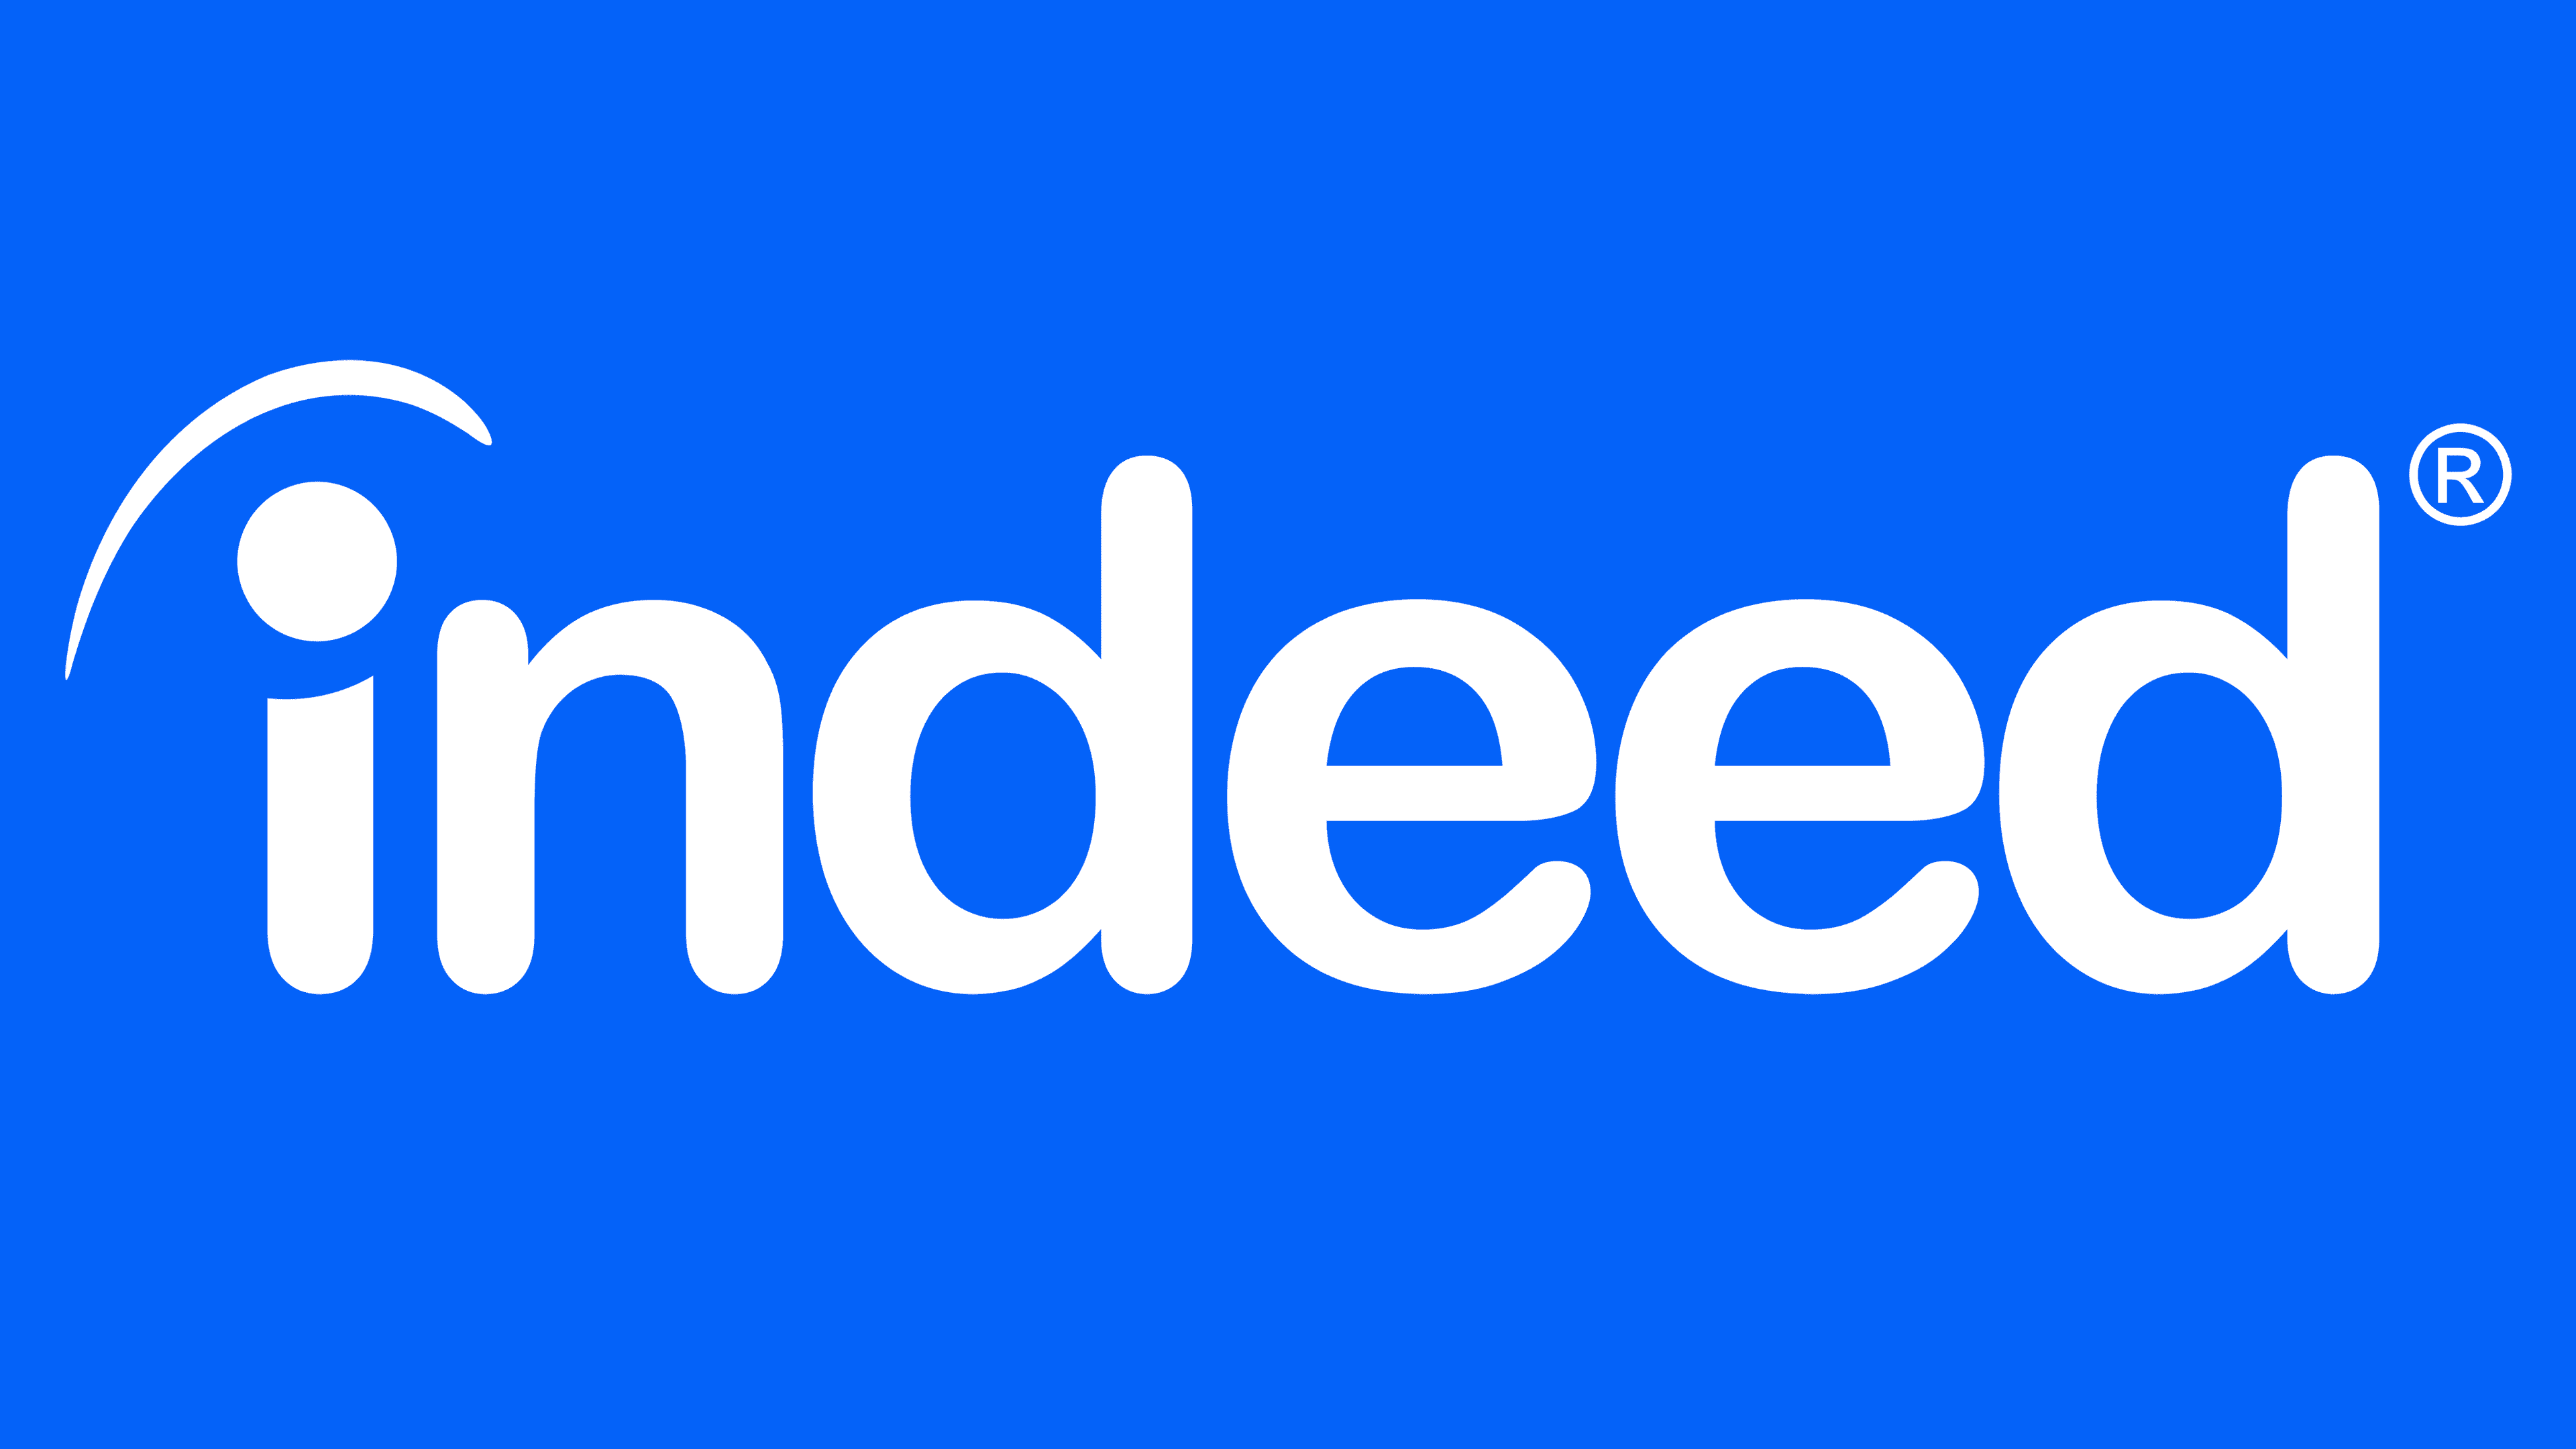

Indeed is one of the biggest websites for job listings and the highest-traffic job website in the United States. As soon-to-be graduates, we spend already quite some time on Indeed looking at jobs for after our Master's degree in Statistics and Data Science. Data Science related jobs are in demand and Indeed is full of them. With our analysis we want to have an insight into the Belgian job market for data related jobs. We want to find out what the demanded skills are and what topics appear in job descriptions.  We are especially interested in the job descriptions for listings appearing under different search terms. Is there a difference between jobs recommended when searching for Data Analyst, Data Scientist, Data Engineer, Machine Learning Engineer and Buisness Intelligence? Since Belgium is a multiligual country, we are interested which job titles are most often posted in English. Finally, we want to find out if the job description is predictive for the search term under which a job appears.

The first step of the analysis is to scrape Indeed to aquire the job descriptions. This poses several challenges as Indeed is not easy to scrape. Once we obtain the text from the scraping we prepare and clean it for our analysis. We will apply some descriptive analysis such as looking at the word frequency distribution and n-grams. We will implement topic modeling with LDA and Top2Vec. Finally, we will build a multiclass classification model on the dataset.

In [ ]:
# Imports for plotting Google trends
%pip install pytrends
from pytrends.request import TrendReq
import plotly.io as pio
import plotly.express as px

# API to get Google search data
pytrends = TrendReq()
pytrends.build_payload(['Data Scientist', 'Data Analyst', 'Data Engineer', 'Machine Learning Engineer', 'Business Intelligence'], timeframe='today 5-y')
df = pytrends.interest_over_time()
# prepare data for plot
df.drop('isPartial', axis=1, inplace=True)
data = pd.melt(df.reset_index(), id_vars='date', var_name = 'search_term', value_name = 'search_volume' )
# plotly 
fig = px.line(data, x="date" , y = "search_volume", color="search_term", line_group = "search_term", labels={"date": "Date", "search_volume": "Search Volume", "search_term": "Search"},
              title="Comparison of Google Searches")
fig.show()

# Imports

In the first step, we import the necessary packages for our anaylsis.

In [ ]:
#Installations
!pip install langdetect
!pip install fake-useragent
!pip install top2vec

#Basic packages
import pandas as pd
import re
import math
import time
import numpy as np
import top2vec

#Web scraping packages
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from langdetect import detect

#NLP packages
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.collocations import *
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#ML packages
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from top2vec import Top2Vec


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Text preparation

Before proceeding to our analyses, we have to pre-process our textual data.  First, we select only the descriptions published in English. Second, the pre-processing is manifold, and it includes:
* Dropping duplicate descriptions;
* Removing descriptions written in an unknown language;
* Removing digits and special symbols;
* Removing HTML tags and URL links;
* Removing stop words.


Third, we lemmatize the descriptions for further analysis. 



The pre-processing of the textual data is an essential step as the web scraped textual data contain a lot of noise that does not have an added value for further analyses. By doing that, we standardize descriptions to facilitate modelling. We read in our textual data. After that, we cross-tabulate each job category with the language of job descriptions.  The first implication is that descriptions in English are dominant across all data-related job categories. Next, descriptions in French are not widespread, while descriptions in Dutch are more common. Likewise, we see that the jobs related to business intelligence and data engineering are the most popular across all languages. It is also the result of web scraping. These two job categories yielded more observations when we scraped *Indeed.com*

In [ ]:
# read in csv file
df = pd.read_csv('jobs_indeed.csv')

# drop possible duplicates
df= df.drop_duplicates()

# remove unknown language
index_names = df[df['Language'] == 'Unknown' ].index
df.drop(index_names, inplace = True)

# replace the '+' sign from the search terms
df['Job_Category'] = df['Job_Category'].str.replace('+',' ')
pd.crosstab(df['Job_Category'], df['Language'])

Language,en,fr,nl
Job_Category,,,
business intelligence,735,46,197
data analyst,363,42,145
data engineer,725,51,456
data scientist,261,30,156
machine learning engineer,219,6,51


Below, we randomly sample descriptions to see what special symbols, characters, and expressions need to be removed. 

In [ ]:
# display some sample descriptions
pd.set_option('display.max_colwidth', 2000)
df.Cleaned_Text.sample(3)

965     Finishing expert Unilin 42 reviews Avelgem Unilin 42 reviews Lees wat andere gebruikers over dit bedrijf te zeggen hebben. Unilin Group  is wereldwijd een referentie in interieurdesign en bouw. We ontwikkelen, produceren en vermarkten  laminaatvloeren, luxe vinyltegels, vinyl op rol, samengesteld parket, tapijttegels, kamerbreed tapijt, panelen op houtbasis en sierpanelen, industriële vloeren, wand- en daksystemen en isolatieplaten . We hebben  7.500 medewerkers  verspreid over  105 locaties  over de hele wereld, waarvan  30 productievestigingen . Samen realiseerden we in 2020 een omzet van  € 2,21 miljard . Onze klanten en partners kennen ons als Unilin, IVC of Godfrey Hirst, of van één van onze merken zoals Quick-Step, Moduleo, Utherm, Pergo, Evola, Xtratherm of ClicWall. Investeren in gepassioneerde mensen, innovatieve merken en duurzame technologie is voor ons vanzelfsprekend.\n Unilin Group is trots om deel uit te maken van Mohawk Industries, wereldwijd marktleider op het 

As we pointed out above, we want to select only the job descriptions written in English. First of all, it will facilitate further analyses as both of us do not speak Dutch and French well. Likewise, we are both internationals looking for English-speaking jobs in Belgium. Once we subset our dataset, we see 2303 job descriptions published in English out of 3889 overall observations. It means that almost 60% of all data-related job postings are published in English, while the other 40% account for either French or Dutch job descriptions. However, it does not necessarily imply that the job description in English requires only the working knowledge of English. It may be the case that decent proficiency in both French and Dutch are solid prerequisites as well. 

In [ ]:
#Number of english job descriptions: 2303 
df_english = df[df["Language"]=="en"].copy()
df_english.shape[0]

2303

Another step of text standardization is to convert all words to lower-case. It helps to reduce the variability of word and letter case noticeably. 

In [ ]:
#lower case the text
df_english['Cleaned_Text'] = df_english['Cleaned_Text'].str.lower()
df_english.Cleaned_Text.sample(5)

3002    energy analyst n-side louvain-la-neuve at n-side, we turn the most complex challenges into opportunities. we are an international and dynamic team of passionate and innovative mathematicians, software engineers and business experts. our integrated optimized solutions facilitate complex business decision-making processes using data analytics, machine learning and other data science approaches. \nwe are looking for an  energy analyst  to join our energy department based in our headquarter in louvain-la-neuve, brussels area, belgium. as an energy analyst, you will help the company be the top reference in advanced analytics solutions for energy challenges around energy markets and power systems and will be strongly involved in key energy projects of n-side. \nwhat you’ll do \nyou will be involved in challenging advanced analytics and ai projects for leading energy players in which you will be developing use cases, from prototypes to operations, in different domains such as asset ma

Next, we remove all newlines, tabs, and returns to eliminate unnecessary symbols like "\n" and "\t" frequently appearing in job descriptions. Likewise, we all other special symbols like digits, nondigits, white space characters, non–white space characters, HTML tags, URL links, punctuation. Additionally, some meaningless and stand-alone symbol collocations like " mm ", " pp ", " hn ", and unfiltered Dutch expressions like "wat andere gebruikers over dit bedrijf te zeggen", "vacature bedrijf", "solliciteer" are deteled as well. 

In [ ]:
# Elimination of special symbols, characters, collocations and expressions 
# The combinations are adapted from Hovy (2020).

df_english = df_english.replace(r'\r+|\n+|\t+','', regex=True) # remove all new lines, all tabs, all returns
df_english = df_english.replace(r'[\S]+\.(net|com|org|info|edu|gov|uk|de|ca|jp|fr|au|us|ru|ch|it|nel|se|no|es|mil)[\S]*\s?','', regex=True) #remove websites
df_english = df_english.replace(r'[^\w\s]','', regex=True) # remove punctuation
df_english = df_english.replace(r'\d+','', regex=True) # remove digits 
df_english = df_english.replace(r'review','', regex=True) # remove the word "review"
df_english = df_english.replace(r'reviews','', regex=True) # remove the word "reviews"
df_english = df_english.replace(r'  s ','', regex=True) # remove "  s " symbol
df_english = df_english.replace(r' mm ','', regex=True) # remove "mm" symbol
df_english = df_english.replace(r' pp ','', regex=True) # remove "pp" symbol
df_english = df_english.replace(r' bb ','', regex=True) # remove "bb" symbol
df_english = df_english.replace(r' q ','', regex=True) # remove "q" symbol
df_english = df_english.replace(r' hn ','', regex=True) # remove "hn" symbol
df_english = df_english.replace(r'httpwwwsosvillagesenfantsbe','', regex=True) # remove "hn" symbol

# remove some Dutch words and phrases

df_english = df_english.replace(r'wat andere gebruikers over dit bedrijf te zeggen','', regex=True)
df_english = df_english.replace(r'vacature bedrijf','', regex=True)
df_english = df_english.replace(r'deze vacature is verlopen op indd mogelijke redenen zijn de werkgever acceptrt momentl gn sollicitaties is niet actief op zoek naar nieuwe medewerkers of is bezig met het beoordelen van sollicitaties','', regex=True)
df_english = df_english.replace(r'bij','', regex=True)
df_english = df_english.replace(r'solliciteer','', regex=True)
df_english = df_english.replace(r'opslaan','', regex=True)
df_english = df_english.replace(r'bijwerkgever','', regex=True)

# check the tidiness of our textual data

df_english.Cleaned_Text.sample(3)

2279    pricing actuary allianzbrussel allianzlees  hebben lets introduce ourselves we are allianz allianz has been the number  insurer worldwide for years something we are proud of but it is easier to get there than to stay we work very hard for this every day we believe it is very important to maintain the good relationship with our brokers and even improve it where possible every day again allianz has therefore deliberately chosen to market our products and services exclusively through professional brokers in belgium allianz is therefore one of the major players in the insurance market we are with more than a thousand colleagues in belgium and that number doubles in our dutch colleagues regarding the role as a  pricing actuary for the motor line of business or nonmotor   you will have a leading role in tariff development and portfolio management exploiting statistical and predictive advanced modelling techniques your key responsibilities lead tariff development and portfolio managem

As it usually turns out, some words often occur in textual data but do not contribute to the analysis and are senseless to utilize. The set of these words is called stopwords (Hovy, 2020). They include determiners, prepositions, pronouns, conjunctions etc. 


Next, we lemmatize the descriptions as we are more interested in the meaning than morphology or syntax (Hovy, 2020).  Lemmatization reduces variability in the textual data and makes it easier to proceed with further statistical analyses. We introduce a stand-alone function to remove stopwords for English and lemmatize the text simultaneously. For this, we use the NLTK package. It has a robust lemmatization function, "WordNetLemmatizer", that treats syntax of words and semantics like speech (Sarkar, 2019)



In [ ]:
# define function for stop word removal and lemmatization
lemmatizer = WordNetLemmatizer()  
stop_words = set(stopwords.words('english'))

def stopwords_lemmatization(document):
  document = " ".join([w for w in document.split(" ") if not w.lower() in stop_words])
  words = nltk.word_tokenize(document)
  text = ""
  for word in words:
    text += " " + lemmatizer.lemmatize(word)
  return text


Below, we apply our function to our description. We check the result by sampling some descriptions from the corpus at random.

In [ ]:
# apply stopwords_lemmatization
df_english["Cleaned_Text"] = df_english.Cleaned_Text.apply(stopwords_lemmatization)
df_english.Cleaned_Text.sample(3)

3794     data scientist raccoon gent transforming complex data using algorithm model create clientoriented solution core challenge youll actively contribute improvement client solution business model operational process automatically translating data reliable information youll create immediate impact broad expertise youll know exactly client need often without realizing experienced data scientist passionate developing algorithm data model wed love chat want data scientist brainjar youre responsible development algorithm model support client decisionmaking process based data youll gathering selecting relevant data responsible translation information enable client reach operational excellence improve andor develop business model issue handling large complex data stream minimum year fulltime experience data scientist theyre talking machine learning artificial intelligence predictive modelling youre eager mingle conversation python spark hadoop secret experience deep learning framework ten